# Modelo de predicción de series de tiempo para la velocidad y dirección del viento usando N-HiTS.

En el presente proyecto se demuestra el desempeño en la predicción de series de tiempo a largo plazo de un nuevo modelo llamado N-HiTS, presentado por Challu et. al. en el año 2022. Dicho modelo aborda dos de los retos actuales más considerables de las predicciones de series de tiempo con modelos neuronales, los cuales son la volatibilidad de las predicciones y su complejidad computacional. De acuerdo con Challu et. al. (2022), el modelo N-HiTS da una solución eficiente a dichos retos gracias a la incorporación de interpolación jerárquica y de técnicas de muestreo de datos de índice multiple, ofreciendo una mejora del 25% en la precisión de las predicciones a la vez que se redujo en una décima parte el tiempo de procesamiento computacional en comparación con los modelos más utilizados en la actualidad. En este proyecto se comparará el desempeño de las redes neuronales recurrentes con arquitectura LSTM con N-HiTS. 

### Series de tiempo del clima

Los datos utilizados para este proyecto fueron recopilados por el Instituto Max Planck de Biogeoquímica y consta de las series de tiempo del clima en la ciudad de Jena, Alemania, desde enero del 2009 a diciembre del 2016. Algunas de las variables atmosféricas registradas en los datos son temperatura, presión atmosférica, humedad, etc., los cuales se detallan más adelante. El registro de los datos fue realizado cada 10 minutos.

__Ubicación__: Estación del clima, [Instituto Max Planck de Biogeoquímica](https://www.bgc-jena.mpg.de/wetter/) en Jena, Alemania.

__Espacio de tiempo considerado__: 10 de enero del 2009 - 31 de diciembre del 2016.

La siguiente tabla contiene una descripción detallada del set de datos utilizados:

| Índice | Variable        | Formato             | Descripción                                                                                                                                                                                                                                        |
|:--------|:-----------------|:---------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1      | Date Time       | 01.01.2009 00:10:00 | Fecha y hora del registro                                                                                                                                                                                                                          |
| 2      | p (mbar)        | 996.52              | La unidad de presión derivada del SI pascal utilizada para cuantificar la presión interna. Los informes meteorológicos suelen indicar la presión atmosférica en milibares.                                                                         |
| 3      | T (degC)        | -8.02               | Temperatura en grados Celsius                                                                                                                                                                                                                      |
| 4      | Tpot (K)        | 265.4               | Temperatura en grados Kelvin                                                                                                                                                                                                                       |
| 5      | Tdew (degC)     | -8.9                | Temperatura en Celsius relativa a la humedad. El punto de rocío. o Dew Point (DW) es una medida de la cantidad absoluta de agua en el aire, el DP es la temperatura a la que el aire no puede retener toda la humedad en él y el agua se condensa. |
| 6      | rh (%)          | 93.3                | La humedad relativa (RH) es una medida de cuán saturado está el aire con vapor de agua, el % de RH determina la cantidad de agua contenida dentro de los objetos de recolección.                                                                   |
| 7      | VPmax (mbar)    | 3.33                | Presión de vapor saturado                                                                                                                                                                                                                          |
| 8      | VPact (mbar)    | 3.11                | Presión de vapor                                                                                                                                                                                                                                   |
| 9      | VPdef (mbar)    | 0.22                | Déficit de presión de vapor                                                                                                                                                                                                                        |
|        |                 |                     |                                                                                                                                                                                                                                                    |
| 10     | sh (g/kg)       | 1.94                | Humedad específica                                                                                                                                                                                                                                 |
| 11     | H2OC (mmol/mol) | 3.12                | Concentración de vapor de agua                                                                                                                                                                                                                     |
| 12     | rho (g/m ** 3)  | 1307.75             | Densidad del aire                                                                                                                                                                                                                                  |
| 13     | wv (m/s)        | 1.03                | Velocidad del viento                                                                                                                                                                                                                               |
| 14     | max. wv (m/s)   | 1.75                | Velocidad máxima del viento                                                                                                                                                                                                                        |
| 15     | wd (deg)        | 152.3               | Dirección del viento en grados

## 1. Importación de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from heatmap import heatmap, corrplot
import tensorflow as tf

In [2]:
df = pd.read_csv('jena_climate_2009_2016.csv', parse_dates = True, index_col = 'Date Time')
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
2016-12-31 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
2016-12-31 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420551 entries, 2009-01-01 00:10:00 to 2017-01-01 00:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420551 non-null  float64
 1   T (degC)         420551 non-null  float64
 2   Tpot (K)         420551 non-null  float64
 3   Tdew (degC)      420551 non-null  float64
 4   rh (%)           420551 non-null  float64
 5   VPmax (mbar)     420551 non-null  float64
 6   VPact (mbar)     420551 non-null  float64
 7   VPdef (mbar)     420551 non-null  float64
 8   sh (g/kg)        420551 non-null  float64
 9   H2OC (mmol/mol)  420551 non-null  float64
 10  rho (g/m**3)     420551 non-null  float64
 11  wv (m/s)         420551 non-null  float64
 12  max. wv (m/s)    420551 non-null  float64
 13  wd (deg)         420551 non-null  float64
dtypes: float64(14)
memory usage: 48.1 MB


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


De acuerdo a lo observado, no hay datos nulos y todos los datos parecen tener valores veraces y certeros, con excepción de la velocidad del viento y la velocidad máxima del viento, pues se aprecia que el valor mínimo de ambos datos es de -9999. Esto no puede ser posible, ya que los sensores miden la rapidez y por lo tanto los valores no pueden ser negativos. Además, una rápidez de 9999 m/s está muy fuera del rango de los valores positivos presentados, los cuales tienen un máximo de 28.49 m/s. En seguida se revisa este problema más a detalle.

In [5]:
df[df['wv (m/s)'] < 0]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2015-07-13 09:10:00,990.49,16.85,290.80,12.78,76.90,19.22,14.78,4.44,9.34,14.92,1183.06,-9999.0,-9999.0,359.7
2015-07-13 09:20:00,990.32,17.06,291.03,12.86,76.30,19.48,14.86,4.62,9.39,15.01,1181.97,-9999.0,-9999.0,359.8
2015-07-13 09:30:00,990.24,17.43,291.41,12.75,74.00,19.94,14.76,5.19,9.32,14.90,1180.42,-9999.0,-9999.0,359.8
2015-07-13 09:40:00,990.27,17.71,291.68,12.88,73.30,20.30,14.88,5.42,9.40,15.02,1179.26,-9999.0,-9999.0,359.8
2015-07-13 09:50:00,990.28,17.76,291.73,13.03,73.80,20.36,15.03,5.33,9.49,15.17,1179.00,-9999.0,-9999.0,359.8
2015-07-13 10:00:00,990.20,17.98,291.96,12.74,71.40,20.65,14.74,5.90,9.31,14.89,1178.14,-9999.0,-9999.0,359.8
2015-07-13 10:10:00,990.17,18.19,292.17,12.59,69.78,20.92,14.60,6.32,9.22,14.74,1177.32,-9999.0,-9999.0,359.8
2015-07-13 10:20:00,990.07,18.31,292.30,12.97,71.00,21.08,14.97,6.11,9.46,15.12,1176.55,-9999.0,-9999.0,359.8
2015-07-13 10:30:00,990.02,18.24,292.24,12.88,70.90,20.99,14.88,6.11,9.40,15.03,1176.82,-9999.0,-9999.0,359.8


In [6]:
df[df['max. wv (m/s)'] < 0]

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2015-07-13 09:00:00,990.52,16.98,290.93,12.94,77.10,19.38,14.94,4.44,9.44,15.09,1182.50,6.16,-9999.0,289.6
2015-07-13 09:10:00,990.49,16.85,290.80,12.78,76.90,19.22,14.78,4.44,9.34,14.92,1183.06,-9999.00,-9999.0,359.7
2015-07-13 09:20:00,990.32,17.06,291.03,12.86,76.30,19.48,14.86,4.62,9.39,15.01,1181.97,-9999.00,-9999.0,359.8
2015-07-13 09:30:00,990.24,17.43,291.41,12.75,74.00,19.94,14.76,5.19,9.32,14.90,1180.42,-9999.00,-9999.0,359.8
2015-07-13 09:40:00,990.27,17.71,291.68,12.88,73.30,20.30,14.88,5.42,9.40,15.02,1179.26,-9999.00,-9999.0,359.8
2015-07-13 09:50:00,990.28,17.76,291.73,13.03,73.80,20.36,15.03,5.33,9.49,15.17,1179.00,-9999.00,-9999.0,359.8
2015-07-13 10:00:00,990.20,17.98,291.96,12.74,71.40,20.65,14.74,5.90,9.31,14.89,1178.14,-9999.00,-9999.0,359.8
2015-07-13 10:10:00,990.17,18.19,292.17,12.59,69.78,20.92,14.60,6.32,9.22,14.74,1177.32,-9999.00,-9999.0,359.8
2015-07-13 10:20:00,990.07,18.31,292.30,12.97,71.00,21.08,14.97,6.11,9.46,15.12,1176.55,-9999.00,-9999.0,359.8


Al parecer hubo una falla en los sensores el día 13 de julio del 2015 entre las 9 de la mañana y las 12 del medio día, pues todos los registros de la velocidad del viento y la velocidad máxima del viento tienen un valor de -9999. Además, se aprecia que justo al inicio y al final de los datos erroneos, los valores de la velocidad son mucho más altos de la media, por lo que éstos también serán sustuidos por la media. Antes de proseguir con las visualizaciones de las series de tiempo, estos datos erroneos se sustituirán por la media correspondiente.

In [7]:
df.loc[df['wv (m/s)'] < 0, 'wv (m/s)'] = df['wv (m/s)'].mean()
df.loc[df['max. wv (m/s)'] < 0, 'max. wv (m/s)'] = df['max. wv (m/s)'].mean()
df.loc[df['wv (m/s)'] > df['max. wv (m/s)'], 'wv (m/s)'] = df['wv (m/s)'].mean()

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


## 2. Visualización de datos

Para tener una mejor idea de los datos, se realizarán visualizaciones de las series de tiempo, en las cuales se podrán apreciar los cambios de las variables a traves de los años. También se creará una gráfica donde se aprecie la correlación que existe entre las variables.

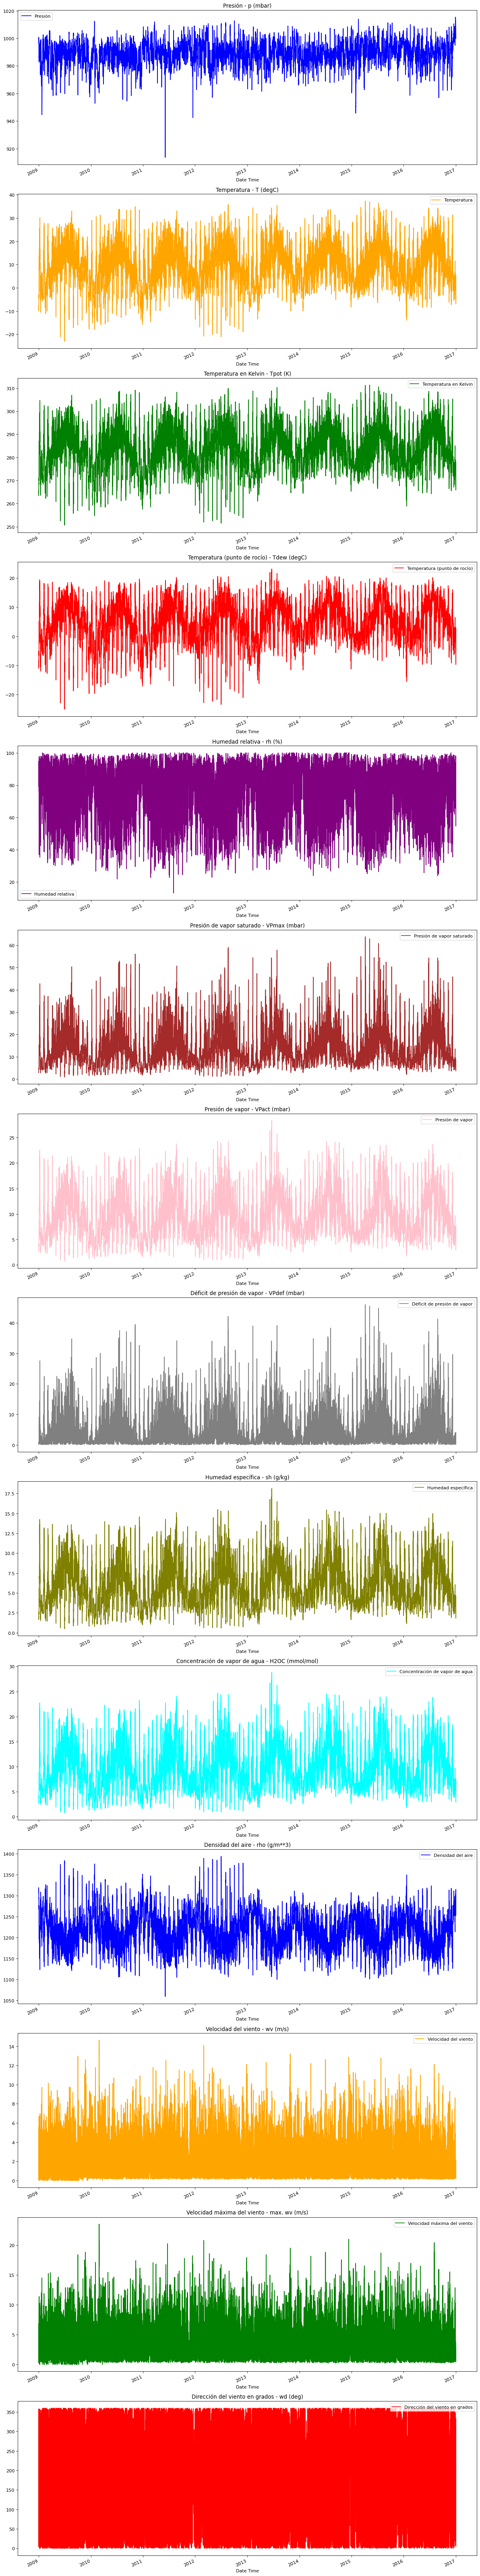

In [8]:
titles = [
    'Presión', 
    'Temperatura', 
    'Temperatura en Kelvin',
    'Temperatura (punto de rocío)',
    'Humedad relativa',
    'Presión de vapor saturado',
    'Presión de vapor',
    'Déficit de presión de vapor',
    'Humedad específica',
    'Concentración de vapor de agua',
    'Densidad del aire',
    'Velocidad del viento',
    'Velocidad máxima del viento',
    'Dirección del viento en grados'
]

feature_keys = [
    'p (mbar)',
    'T (degC)',
    'Tpot (K)',
    'Tdew (degC)',
    'rh (%)',
    'VPmax (mbar)',
    'VPact (mbar)',
    'VPdef (mbar)',
    'sh (g/kg)',
    'H2OC (mmol/mol)',
    'rho (g/m**3)',
    'wv (m/s)',
    'max. wv (m/s)',
    'wd (deg)'
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]


def show_visualization(data):
    time_data = data.index
    fig, axes = plt.subplots(
        nrows=14, ncols=1, figsize=(15, 80), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i],
            color=c,
            title=f'{titles[i]} - {key}',
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_visualization(df)

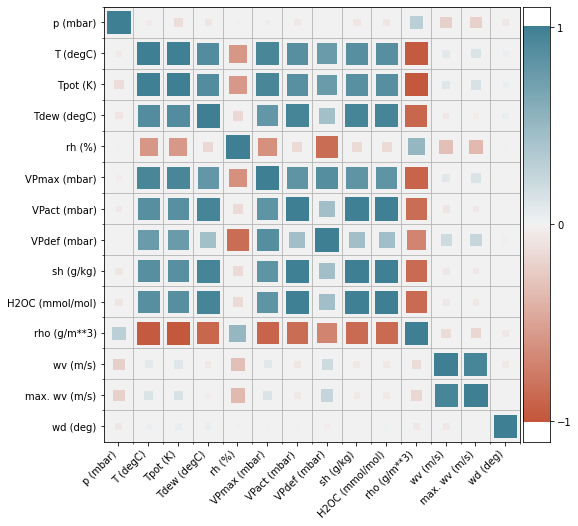

In [9]:
plt.figure(figsize=(8, 8))
corrplot(df.corr(), size_scale=500)

## 3. Procesamiento de datos

Dado que no se espera un gran cambio en las variables cada 10 minutos, se tomará en cuenta únicamente una observación por hora, esto ayudará a utilizar menos recursos computacionales y evitará que el modelo se sobrealimente. Al hacer esto, el tamaño del dataframe pasará de 420551 entradas a 70091 entradas, de las cuales 49000 se usarán para entrenar al modelo, 7000 para validarlo y el resto para hacer pruebas.

Como se observa en el mapa de correlación, algunas de las variables como "Temperatura en grados Kelvin" y "Punto de rocío" son redundantes, por lo que en el modelo se usarán unicamente las variables relevantes, las cuales se considera que son _presión_, _temperatura_, _presión de vapor saturado_, _déficit de presión de vapor_, _humedad específica_, _densidad del aire_ y _velocidad del viento_.

El modeló analizará los datos de 24 horas atras (un día) y estos datos se utilizarán para predecir el siguiente valor de la velocidad del viento. 

Debido a los rangos tan distintos de los valores de cada variable, se llevará a cabo una normalización para confinar los valores a un rango de aproximadamente -10 y 10 antes de entrenar la red neuronal. Esto se realizará convirtiendo los valores a su puntuacion estándar, la cual se refiere al número de desviaciones estándar que hay por encima o por debajo de la media y se calcula restando la media al valor original y dividiendo este resultado entre la desviación estándar.

In [10]:
#observaciones reducidas a una cada hora
df = df[5::6]

#normalización de datos 
mean = df.mean()
std = df.std()
df = (df - mean)/std

df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 01:00:00,0.871786,-2.077607,-2.129843,-2.041056,1.116255,-1.323867,-1.528320,-0.786465,-1.529687,-1.532621,2.296447,-1.244719,-1.239229,0.206777
2009-01-01 02:00:00,0.886142,-2.176142,-2.228615,-2.188157,1.043417,-1.350999,-1.585686,-0.782382,-1.586166,-1.589293,2.406267,-1.218795,-1.239229,0.179070
2009-01-01 03:00:00,0.912461,-2.167832,-2.222736,-2.171812,1.061626,-1.349707,-1.578515,-0.784423,-1.578636,-1.582209,2.404516,-1.264162,-1.239229,-0.087614
2009-01-01 04:00:00,0.930406,-2.196324,-2.252132,-2.225303,1.006998,-1.357459,-1.597637,-0.778299,-1.597462,-1.603461,2.440289,-1.316010,-1.345918,0.752844
2009-01-01 05:00:00,0.986634,-2.265180,-2.325035,-2.318913,0.982719,-1.374255,-1.631101,-0.778299,-1.631350,-1.636520,2.529847,-1.121579,-1.132540,-0.205371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:10:00,1.551302,-1.238277,-1.350248,-1.532890,-0.243387,-1.018953,-1.301246,-0.500666,-1.311298,-1.313015,1.617010,-0.816970,-0.927698,0.182533
2016-12-31 20:10:00,1.457988,-1.288138,-1.391404,-1.752798,-0.589975,-1.042209,-1.406417,-0.445548,-1.412961,-1.414553,1.646278,-0.719755,-0.688716,0.584290
2016-12-31 21:10:00,1.432865,-1.448406,-1.548969,-1.761713,-0.188759,-1.109393,-1.408807,-0.549660,-1.416727,-1.419276,1.800127,-0.920667,-0.842347,-0.185745


In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,6.922136e-13,1.0,-9.045804,-0.599702,0.042728,0.658839,3.119693
T (degC),70091.0,-1.425450e-16,1.0,-3.823936,-0.724232,-0.004806,0.715807,3.303841
Tpot (K),70091.0,3.386723e-15,1.0,-3.838365,-0.711757,-0.003890,0.709856,3.259117
Tdew (degC),70091.0,9.503057e-15,1.0,-4.421413,-0.700805,0.037671,0.761288,2.689942
rh (%),70091.0,6.080659e-14,1.0,-3.771174,-0.655529,0.199710,0.812763,1.456166
VPmax (mbar),70091.0,2.487111e-15,1.0,-1.628781,-0.750215,-0.226951,0.521122,6.485036
VPact (mbar),70091.0,3.383900e-15,1.0,-2.085249,-0.792122,-0.161095,0.675493,4.473604
VPdef (mbar),70091.0,2.389846e-15,1.0,-0.825252,-0.647648,-0.378181,0.256701,8.567326
sh (g/kg),70091.0,5.487021e-15,1.0,-2.075659,-0.791683,-0.162873,0.669264,4.536254
H2OC (mmol/mol),70091.0,9.683693e-15,1.0,-2.085177,-0.791156,-0.160675,0.672882,4.510079


Dado que las variables atmosféricas tienen cambios fluctuantes a lo largo del año, un último paso antes de pasar a construir los datasets de entrenamiento, validacion y prueba, será utilizar el seno y el coseno de las variaciones periódicas para que nuestro modelo también considere estas fluctuaciones, pues no será igual predecir en los días fríos de invierno que en días secos y calurosos del verano. Para esto, añadiremos 4 nuevas columnas con el seno y el coseno del correspondiente día de cada año. Eliminaremos además las columnas con variales redundantes.

In [12]:
df['Seconds'] = df.index.map(pd.Timestamp.timestamp)
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),Seconds
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,0.871786,-2.077607,-2.129843,-2.041056,1.116255,-1.323867,-1.528320,-0.786465,-1.529687,-1.532621,2.296447,-1.244719,-1.239229,0.206777,1.230772e+09
2009-01-01 02:00:00,0.886142,-2.176142,-2.228615,-2.188157,1.043417,-1.350999,-1.585686,-0.782382,-1.586166,-1.589293,2.406267,-1.218795,-1.239229,0.179070,1.230775e+09
2009-01-01 03:00:00,0.912461,-2.167832,-2.222736,-2.171812,1.061626,-1.349707,-1.578515,-0.784423,-1.578636,-1.582209,2.404516,-1.264162,-1.239229,-0.087614,1.230779e+09
2009-01-01 04:00:00,0.930406,-2.196324,-2.252132,-2.225303,1.006998,-1.357459,-1.597637,-0.778299,-1.597462,-1.603461,2.440289,-1.316010,-1.345918,0.752844,1.230782e+09
2009-01-01 05:00:00,0.986634,-2.265180,-2.325035,-2.318913,0.982719,-1.374255,-1.631101,-0.778299,-1.631350,-1.636520,2.529847,-1.121579,-1.132540,-0.205371,1.230786e+09


In [13]:
#variables que corresponden al número de segundos en un día y en un año, respectivamente
day = 60*60*24
year = 365.2425*day

#creación de las 4 columnas correspondientes al seno y al coseno, que se agregarán a las últimas columnas
df['Day sin'] = np.sin(df['Seconds'] * (2* np.pi / day))
df['Day cos'] = np.cos(df['Seconds'] * (2 * np.pi / day))
df['Year sin'] = np.sin(df['Seconds'] * (2 * np.pi / year))
df['Year cos'] = np.cos(df['Seconds'] * (2 * np.pi / year))
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),Seconds,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,,,,,,,,,,,,,,
2009-01-01 01:00:00,0.871786,-2.077607,-2.129843,-2.041056,1.116255,-1.323867,-1.528320,-0.786465,-1.529687,-1.532621,2.296447,-1.244719,-1.239229,0.206777,1.230772e+09,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,0.886142,-2.176142,-2.228615,-2.188157,1.043417,-1.350999,-1.585686,-0.782382,-1.586166,-1.589293,2.406267,-1.218795,-1.239229,0.179070,1.230775e+09,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,0.912461,-2.167832,-2.222736,-2.171812,1.061626,-1.349707,-1.578515,-0.784423,-1.578636,-1.582209,2.404516,-1.264162,-1.239229,-0.087614,1.230779e+09,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,0.930406,-2.196324,-2.252132,-2.225303,1.006998,-1.357459,-1.597637,-0.778299,-1.597462,-1.603461,2.440289,-1.316010,-1.345918,0.752844,1.230782e+09,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,0.986634,-2.265180,-2.325035,-2.318913,0.982719,-1.374255,-1.631101,-0.778299,-1.631350,-1.636520,2.529847,-1.121579,-1.132540,-0.205371,1.230786e+09,0.965926,0.258819,0.012916,0.999917


In [14]:
#eliminación de las columnas innecesarias
df = df.drop(labels=['Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPact (mbar)', 'H2OC (mmol/mol)', 'max. wv (m/s)', 'wd (deg)', 'Seconds'], axis=1)
df.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s),Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,,,,,,
2009-01-01 01:00:00,0.871786,-2.077607,-1.323867,-0.786465,-1.529687,2.296447,-1.244719,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,0.886142,-2.176142,-1.350999,-0.782382,-1.586166,2.406267,-1.218795,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,0.912461,-2.167832,-1.349707,-0.784423,-1.578636,2.404516,-1.264162,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,0.930406,-2.196324,-1.357459,-0.778299,-1.597462,2.440289,-1.316010,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,0.986634,-2.265180,-1.374255,-0.778299,-1.631350,2.529847,-1.121579,0.965926,0.258819,0.012916,0.999917


## 4. Creación de los datasets de entrenamiento, validación y prueba

Tal como se aprecia en el dataframe de arriba, los datos se encuentran listos para trabajar con ellos, así que estos datos se divirán en 3 partes: entrenamiento, validación y prueba. El 70% de los datos se utilizarán para entrenar al modelo, el 10% para hacer una validación y el 20% restante para probar el modelo. Este proceso se muestra a continuación.

In [15]:
#esta función convierte el dataframe al formato correspondiente para alimentar el modelo. La lista X será un tensor con todas
#las variables y la lista y será el vector con nuestra variable a predecir, es decir, la velocidad del viento correspondiente
def df_to_X_y(df, window_size=24):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][6]
    y.append(label)
  return np.array(X), np.array(y)

In [16]:
#creación de los argumentos X (tensor con variables) y y (vector con labels) que alimentarán al modelo.
#al revisar la forma vemos que hay 70019 entradas, que corresponden al dataframe inicial menos el tamaño de la ventana; 24, que
#se refiere al tamaño de la ventana y 11, que es el número de variables
X, y = df_to_X_y(df)
X.shape, y.shape

((70067, 24, 11), (70067,))

In [17]:
#creación del dataset de entrenamiento
X_train, y_train = X[:49000], y[:49000]
#creación del dataset de entrenamiento
X_val, y_val = X[49000:56000], y[49000:56000]
#creación del dataset de entrenamiento
X_test, y_test = X[56000:], y[56000:]

#revisión de las formas de los tensores y los vectores
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((49000, 24, 11), (49000,), (7000, 24, 11), (7000,), (14067, 24, 11), (14067,))

## 5. Compilación y entrenamiento de los modelos

Se compilarán 4 modelos distintos y se hará una comparación entre el desempeño de cada uno. Los 3 modelos a crear serán dos RNN LSTM, una sencilla y otra con una capa secuencial; una RNN GRU y una CNN.

### 5a) RNN con arquitectura LSTM sencilla

In [18]:
#Importación de las librerías de tensorflow para la creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [19]:
#creación del modelo
model1 = Sequential()
model1.add(InputLayer((24, 11)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19456     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 19,985
Trainable params: 19,985
Non-trainable params: 0
_________________________________________________________________


In [20]:
#creación de un checkpoint para guardar en la memoria el modelo con el mejor loss en los datos de validación
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [21]:
#entrenamento y ajuste del modelo
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1])

Epoch 1/10
1532/1532 [==============================] - ETA: 0s - loss: 0.4602 - root_mean_squared_error: 0.6784

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1532/1532 [==============================] - 61s 36ms/step - loss: 0.4602 - root_mean_squared_error: 0.6784 - val_loss: 0.3439 - val_root_mean_squared_error: 0.5864
Epoch 2/10
1530/1532 [============================>.] - ETA: 0s - loss: 0.3401 - root_mean_squared_error: 0.5832

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1532/1532 [==============================] - 55s 36ms/step - loss: 0.3401 - root_mean_squared_error: 0.5832 - val_loss: 0.3235 - val_root_mean_squared_error: 0.5688
Epoch 3/10
1532/1532 [==============================] - ETA: 0s - loss: 0.3294 - root_mean_squared_error: 0.5739

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1532/1532 [==============================] - 59s 39ms/step - loss: 0.3294 - root_mean_squared_error: 0.5739 - val_loss: 0.3210 - val_root_mean_squared_error: 0.5666
Epoch 4/10
1532/1532 [==============================] - ETA: 0s - loss: 0.3272 - root_mean_squared_error: 0.5720

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1532/1532 [==============================] - 58s 38ms/step - loss: 0.3272 - root_mean_squared_error: 0.5720 - val_loss: 0.3203 - val_root_mean_squared_error: 0.5660
Epoch 5/10
1532/1532 [==============================] - ETA: 0s - loss: 0.3256 - root_mean_squared_error: 0.5706

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1532/1532 [==============================] - 58s 38ms/step - loss: 0.3256 - root_mean_squared_error: 0.5706 - val_loss: 0.3186 - val_root_mean_squared_error: 0.5645
Epoch 6/10
1532/1532 [==============================] - ETA: 0s - loss: 0.3248 - root_mean_squared_error: 0.5699

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1532/1532 [==============================] - 59s 39ms/step - loss: 0.3248 - root_mean_squared_error: 0.5699 - val_loss: 0.3166 - val_root_mean_squared_error: 0.5627
Epoch 7/10
1532/1532 [==============================] - 48s 31ms/step - loss: 0.3236 - root_mean_squared_error: 0.5689 - val_loss: 0.3184 - val_root_mean_squared_error: 0.5643
Epoch 8/10
1532/1532 [==============================] - 48s 31ms/step - loss: 0.3229 - root_mean_squared_error: 0.5683 - val_loss: 0.3178 - val_root_mean_squared_error: 0.5637
Epoch 9/10
1531/1532 [============================>.] - ETA: 0s - loss: 0.3223 - root_mean_squared_error: 0.5678

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1532/1532 [==============================] - 58s 38ms/step - loss: 0.3223 - root_mean_squared_error: 0.5677 - val_loss: 0.3157 - val_root_mean_squared_error: 0.5619
Epoch 10/10
1532/1532 [==============================] - 48s 31ms/step - loss: 0.3214 - root_mean_squared_error: 0.5669 - val_loss: 0.3164 - val_root_mean_squared_error: 0.5625


A continuación se creará una función para desnormalizar los valores y para visualizar el desempeño de los modelos. La función de desnormalización convertirá los valores normalizados del viento a sus valores correspondientes.

In [22]:
def postprocess_wind(arr):
  arr = (arr*std['wv (m/s)']) + mean['wv (m/s)']
  return arr

In [23]:
def plot_predictions(model, X, y, start=0, end=500):
  predictions = model.predict(X).flatten()
  wind_preds = postprocess_wind(predictions[:])
  wind_actuals = postprocess_wind(y[:])
  df = pd.DataFrame(data={'Prediccion viento': wind_preds,
                          'Real viento': wind_actuals
                          })
  plt.figure(figsize=(20, 6))
  plt.plot(df['Prediccion viento'][start:end], label='Valor predicho')
  plt.plot(df['Real viento'][start:end], label='Valor real')
  plt.xlabel('Medición')
  plt.ylabel('Valor (m/s)')
  plt.title('Comparación entre el valor predicho y el valor real')
  plt.legend()
  return df[start:end]

,Prediccion viento,Real viento
0,1.840681,2.40
1,1.740272,0.95
2,1.149036,0.38
3,0.790591,0.35
4,0.627165,1.34
...,...,...
495,2.426838,1.20
496,2.203738,1.23
497,2.134088,1.40
498,2.078505,1.66


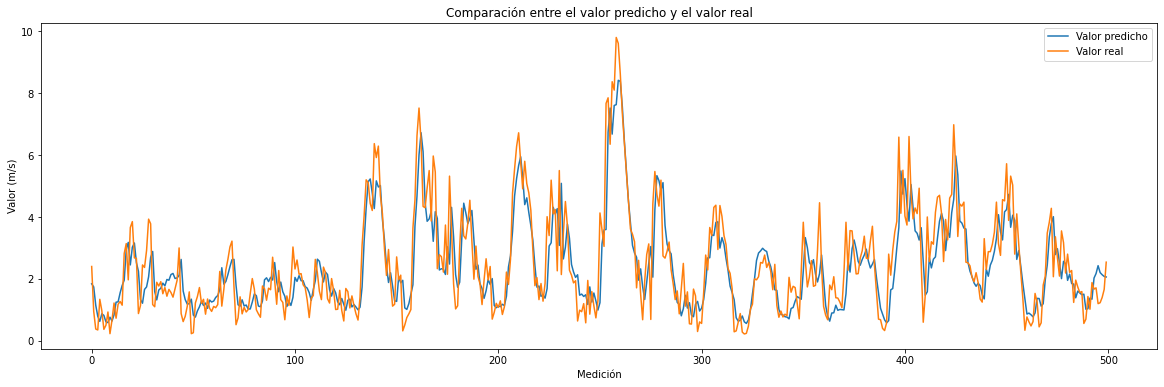

In [24]:
#visualización del modelo
plot_predictions(model1, X_test, y_test)

### 5b) RNN con arquitectura LSTM secuencial

In [25]:
#creación del modelo
model2 = Sequential()
model2.add(InputLayer((24, 11)))
model2.add(LSTM(32, return_sequences=True))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24, 32)            5632      
                                                                 
 lstm_2 (LSTM)               (None, 64)                24832     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 30,993
Trainable params: 30,993
Non-trainable params: 0
_________________________________________________________________


In [26]:
#creación de un checkpoint para guardar en la memoria el modelo con el mejor loss en los datos de validación
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [27]:
#entrenamento y ajuste del modelo
model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp2])

Epoch 1/10
1532/1532 [==============================] - ETA: 0s - loss: 0.5473 - root_mean_squared_error: 0.7398

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1532/1532 [==============================] - 116s 70ms/step - loss: 0.5473 - root_mean_squared_error: 0.7398 - val_loss: 0.3981 - val_root_mean_squared_error: 0.6309
Epoch 2/10
1532/1532 [==============================] - ETA: 0s - loss: 0.3696 - root_mean_squared_error: 0.6079

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1532/1532 [==============================] - 103s 67ms/step - loss: 0.3696 - root_mean_squared_error: 0.6079 - val_loss: 0.3389 - val_root_mean_squared_error: 0.5821
Epoch 3/10
1531/1532 [============================>.] - ETA: 0s - loss: 0.3367 - root_mean_squared_error: 0.5803

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1532/1532 [==============================] - 106s 69ms/step - loss: 0.3367 - root_mean_squared_error: 0.5803 - val_loss: 0.3255 - val_root_mean_squared_error: 0.5705
Epoch 4/10
1532/1532 [==============================] - ETA: 0s - loss: 0.3306 - root_mean_squared_error: 0.5750

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1532/1532 [==============================] - 102s 66ms/step - loss: 0.3306 - root_mean_squared_error: 0.5750 - val_loss: 0.3236 - val_root_mean_squared_error: 0.5689
Epoch 5/10
1531/1532 [============================>.] - ETA: 0s - loss: 0.3287 - root_mean_squared_error: 0.5733

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1532/1532 [==============================] - 105s 69ms/step - loss: 0.3288 - root_mean_squared_error: 0.5734 - val_loss: 0.3204 - val_root_mean_squared_error: 0.5660
Epoch 6/10
1532/1532 [==============================] - ETA: 0s - loss: 0.3271 - root_mean_squared_error: 0.5719

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1532/1532 [==============================] - 102s 67ms/step - loss: 0.3271 - root_mean_squared_error: 0.5719 - val_loss: 0.3195 - val_root_mean_squared_error: 0.5652
Epoch 7/10
1532/1532 [==============================] - ETA: 0s - loss: 0.3261 - root_mean_squared_error: 0.5711

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1532/1532 [==============================] - 99s 64ms/step - loss: 0.3261 - root_mean_squared_error: 0.5711 - val_loss: 0.3190 - val_root_mean_squared_error: 0.5648
Epoch 8/10
1532/1532 [==============================] - ETA: 0s - loss: 0.3249 - root_mean_squared_error: 0.5700

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1532/1532 [==============================] - 103s 68ms/step - loss: 0.3249 - root_mean_squared_error: 0.5700 - val_loss: 0.3183 - val_root_mean_squared_error: 0.5641
Epoch 9/10
1532/1532 [==============================] - 85s 56ms/step - loss: 0.3246 - root_mean_squared_error: 0.5698 - val_loss: 0.3185 - val_root_mean_squared_error: 0.5643
Epoch 10/10
1532/1532 [==============================] - 86s 56ms/step - loss: 0.3237 - root_mean_squared_error: 0.5689 - val_loss: 0.3201 - val_root_mean_squared_error: 0.5657


,Prediccion viento,Real viento
0,1.971370,2.40
1,1.867158,0.95
2,1.239011,0.38
3,0.876110,0.35
4,0.755702,1.34
...,...,...
495,2.478373,1.20
496,2.251171,1.23
497,2.182062,1.40
498,2.161687,1.66


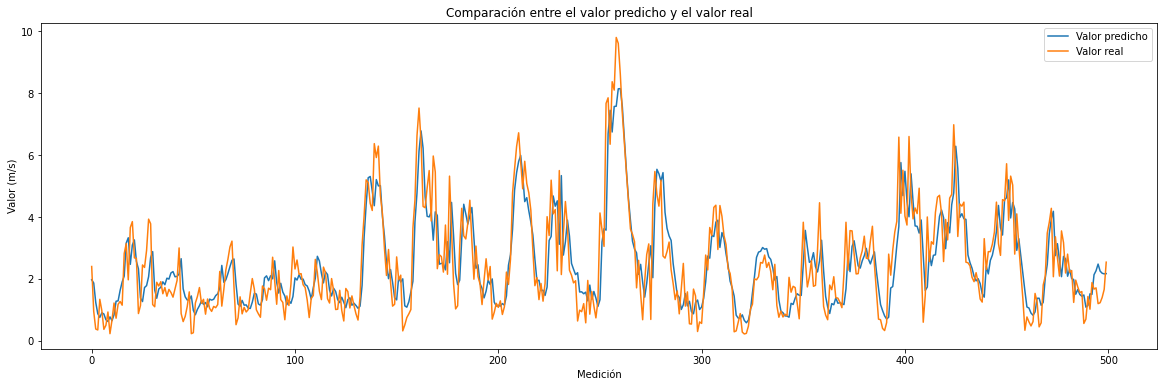

In [28]:
#visualización del modelo
plot_predictions(model2, X_test, y_test)

### 5c) RNN con arquitectura GRU sencilla

In [29]:
#creación del modelo
model3 = Sequential()
model3.add(InputLayer((24, 11)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                14784     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 15,313
Trainable params: 15,313
Non-trainable params: 0
_________________________________________________________________


In [30]:
#creación de un checkpoint para guardar en la memoria el modelo con el mejor loss en los datos de validación
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [31]:
#entrenamento y ajuste del modelo
model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp3])

Epoch 1/10
1532/1532 [==============================] - ETA: 0s - loss: 0.4955 - root_mean_squared_error: 0.7039

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1532/1532 [==============================] - 60s 36ms/step - loss: 0.4955 - root_mean_squared_error: 0.7039 - val_loss: 0.3347 - val_root_mean_squared_error: 0.5786
Epoch 2/10
1531/1532 [============================>.] - ETA: 0s - loss: 0.3357 - root_mean_squared_error: 0.5794

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1532/1532 [==============================] - 65s 43ms/step - loss: 0.3357 - root_mean_squared_error: 0.5794 - val_loss: 0.3245 - val_root_mean_squared_error: 0.5696
Epoch 3/10
1531/1532 [============================>.] - ETA: 0s - loss: 0.3295 - root_mean_squared_error: 0.5741

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1532/1532 [==============================] - 61s 40ms/step - loss: 0.3295 - root_mean_squared_error: 0.5740 - val_loss: 0.3197 - val_root_mean_squared_error: 0.5655
Epoch 4/10
1532/1532 [==============================] - ETA: 0s - loss: 0.3270 - root_mean_squared_error: 0.5718

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1532/1532 [==============================] - 64s 42ms/step - loss: 0.3270 - root_mean_squared_error: 0.5718 - val_loss: 0.3178 - val_root_mean_squared_error: 0.5638
Epoch 5/10
1532/1532 [==============================] - 51s 33ms/step - loss: 0.3256 - root_mean_squared_error: 0.5706 - val_loss: 0.3179 - val_root_mean_squared_error: 0.5638
Epoch 6/10
1532/1532 [==============================] - ETA: 0s - loss: 0.3248 - root_mean_squared_error: 0.5699

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1532/1532 [==============================] - 60s 39ms/step - loss: 0.3248 - root_mean_squared_error: 0.5699 - val_loss: 0.3161 - val_root_mean_squared_error: 0.5622
Epoch 7/10
1532/1532 [==============================] - ETA: 0s - loss: 0.3238 - root_mean_squared_error: 0.5690

INFO:tensorflow:Assets written to: model3\assets


INFO:tensorflow:Assets written to: model3\assets


1532/1532 [==============================] - 64s 42ms/step - loss: 0.3238 - root_mean_squared_error: 0.5690 - val_loss: 0.3154 - val_root_mean_squared_error: 0.5616
Epoch 8/10
1532/1532 [==============================] - 54s 35ms/step - loss: 0.3228 - root_mean_squared_error: 0.5682 - val_loss: 0.3164 - val_root_mean_squared_error: 0.5625
Epoch 9/10
1532/1532 [==============================] - 52s 34ms/step - loss: 0.3224 - root_mean_squared_error: 0.5678 - val_loss: 0.3159 - val_root_mean_squared_error: 0.5620
Epoch 10/10
1532/1532 [==============================] - 52s 34ms/step - loss: 0.3221 - root_mean_squared_error: 0.5675 - val_loss: 0.3154 - val_root_mean_squared_error: 0.5616


,Prediccion viento,Real viento
0,1.991178,2.40
1,1.879377,0.95
2,1.186644,0.38
3,0.865827,0.35
4,0.733677,1.34
...,...,...
495,2.377211,1.20
496,2.126721,1.23
497,2.069385,1.40
498,2.060521,1.66


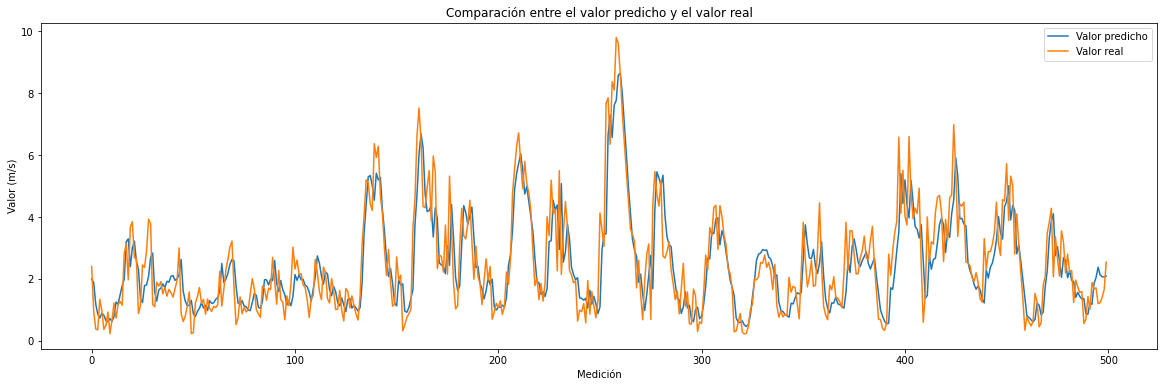

In [32]:
#visualización del modelo
plot_predictions(model3, X_test, y_test)

### 5d) CNN conv1D

In [33]:
#creación del modelo
model4 = Sequential()
model4.add(InputLayer((24, 11)))
model4.add(Conv1D(64, kernel_size=2, activation='relu'))
model4.add(Flatten())
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 64)            1472      
                                                                 
 flatten (Flatten)           (None, 1472)              0         
                                                                 
 dense_6 (Dense)             (None, 8)                 11784     
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13,265
Trainable params: 13,265
Non-trainable params: 0
_________________________________________________________________


In [34]:
#creación de un checkpoint para guardar en la memoria el modelo con el mejor loss en los datos de validación
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [35]:
#entrenamento y ajuste del modelo
model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp4])

Epoch 1/10
1531/1532 [============================>.] - ETA: 0s - loss: 0.4369 - root_mean_squared_error: 0.6610INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1532/1532 [==============================] - 15s 9ms/step - loss: 0.4369 - root_mean_squared_error: 0.6610 - val_loss: 0.3422 - val_root_mean_squared_error: 0.5850
Epoch 2/10
1523/1532 [============================>.] - ETA: 0s - loss: 0.3457 - root_mean_squared_error: 0.5880INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1532/1532 [==============================] - 13s 8ms/step - loss: 0.3459 - root_mean_squared_error: 0.5881 - val_loss: 0.3347 - val_root_mean_squared_error: 0.5786
Epoch 3/10
1530/1532 [============================>.] - ETA: 0s - loss: 0.3379 - root_mean_squared_error: 0.5813INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1532/1532 [==============================] - 14s 9ms/step - loss: 0.3378 - root_mean_squared_error: 0.5812 - val_loss: 0.3272 - val_root_mean_squared_error: 0.5720
Epoch 4/10
1531/1532 [============================>.] - ETA: 0s - loss: 0.3345 - root_mean_squared_error: 0.5783INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1532/1532 [==============================] - 13s 9ms/step - loss: 0.3344 - root_mean_squared_error: 0.5783 - val_loss: 0.3268 - val_root_mean_squared_error: 0.5717
Epoch 5/10
1532/1532 [==============================] - 11s 7ms/step - loss: 0.3307 - root_mean_squared_error: 0.5750 - val_loss: 0.3318 - val_root_mean_squared_error: 0.5760
Epoch 6/10
1532/1532 [==============================] - 12s 8ms/step - loss: 0.3289 - root_mean_squared_error: 0.5735 - val_loss: 0.3277 - val_root_mean_squared_error: 0.5724
Epoch 7/10
1532/1532 [==============================] - 12s 8ms/step - loss: 0.3275 - root_mean_squared_error: 0.5723 - val_loss: 0.3323 - val_root_mean_squared_error: 0.5764
Epoch 8/10
1530/1532 [============================>.] - ETA: 0s - loss: 0.3254 - root_mean_squared_error: 0.5704INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1532/1532 [==============================] - 14s 9ms/step - loss: 0.3255 - root_mean_squared_error: 0.5706 - val_loss: 0.3231 - val_root_mean_squared_error: 0.5684
Epoch 9/10
1531/1532 [============================>.] - ETA: 0s - loss: 0.3248 - root_mean_squared_error: 0.5699INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1532/1532 [==============================] - 14s 9ms/step - loss: 0.3248 - root_mean_squared_error: 0.5699 - val_loss: 0.3207 - val_root_mean_squared_error: 0.5663
Epoch 10/10
1532/1532 [==============================] - 12s 8ms/step - loss: 0.3231 - root_mean_squared_error: 0.5684 - val_loss: 0.3232 - val_root_mean_squared_error: 0.5685


,Prediccion viento,Real viento
0,2.049807,2.40
1,1.970193,0.95
2,1.186385,0.38
3,0.800361,0.35
4,0.840625,1.34
...,...,...
495,2.560651,1.20
496,1.978106,1.23
497,1.946819,1.40
498,1.839941,1.66


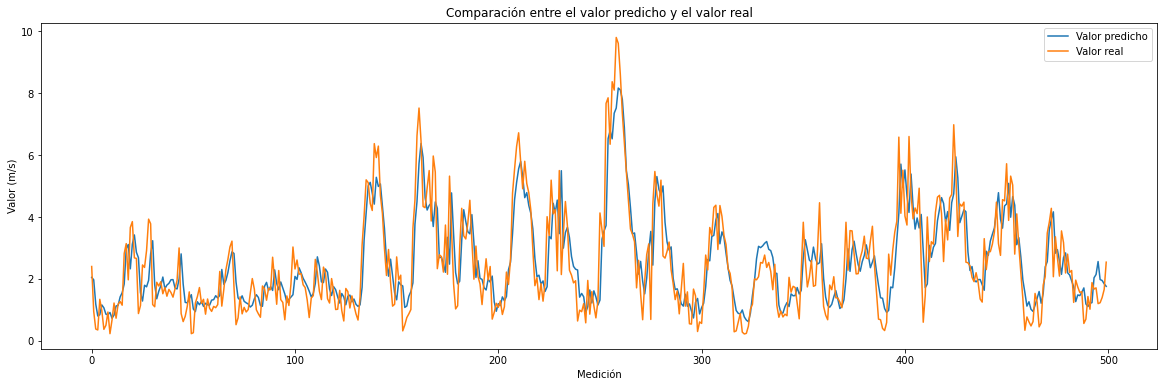

In [36]:
#visualización del modelo
plot_predictions(model4, X_test, y_test)